This notebook implemeting all necessery process to obtain the spectra that will be used in my Doctorate degreee

In [1]:
import os
import re
import requests
import zipfile
import json
import datetime
import shutil

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from scipy import interpolate

from astropy.time import Time

# WISeREP

The main webpage is: [WISeREP](https://www.wiserep.org/)

## Download data

In [1]:
WISeREP                = "www.wiserep.org"
url_wis_spectra_search = "https://" + WISeREP + "/search/spectra"

# Specify the Personal api key here (*** MUST BE PROVIDED ***)
personal_api_key       = "9da72158cebc45da6305466dd99895b079219f6b"
# for User-Agent:
WIS_USER_NAME          = "Steve Jurado"
WIS_USER_ID            = "Steve Jurado"

In [3]:
supernovae_types = {
    1: 'SN', 2: 'SN I', 3: 'SN Ia', 4: 'SN Ib', 5: 'SN Ic', 6: 'SN Ib/c',
    7: 'SN Ic-BL', 9: 'SN Ibn', 10: 'SN II', 11: 'SN IIP', 12: 'SN IIL', 13: 'SN IIn', 14: 'SN IIb', 15: 'SN I-faint', 16: 'SN I-rapid',
    18: 'SLSN-I', 19: 'SNLS-II', 20: 'SNSN-R',
    100: 'SN ia-pec', 102: 'SN ia-SC', 103: 'SN Ia-91bg-like', 104: 'SN Ia-91T-like', 105: 'SN iax[02cx-like]', 106: 'Sn Ia-CSM',
    107: 'SN ib-pec', 108: 'SN Ic-pec', 109: 'SN Icn', 110: 'SN Ibn/Icn',
    111: 'SN II-pec', 112: 'SN IIn-pec', 115: 'SN Ib-Ca-rich', 116: 'SN Ib7c-Ca-rich', 117: 'SN Ic-Ca-rich', 118: 'SN Ia-Ca-rich'
}

# spectypes = {10: 'Object', 50: 'Synthetic'}

query_params    = "&public=yes&type[]="+"["+",".join(str(x) for x in supernovae_types.keys())+']'+"&spectypes[]=10"
download_params_html = "&num_page=250&format=html&files_type=ascii"
download_params_csv = "&num_page=250&format=csv&files_type=ascii"
download_params = download_params_csv

parameters_csv = "?" + query_params+download_params_csv + "&personal_api_key=" + personal_api_key
parameters_html = "?" + query_params+download_params_html + "&personal_api_key=" + personal_api_key

# url of wiserep spectra search (with parameters)
URL      = url_wis_spectra_search + parameters_csv
URL_html = url_wis_spectra_search + parameters_html

print('The URL of WISeREP spectra search is:\n',URL_html)

The URL of WISeREP spectra search is:
 https://www.wiserep.org/search/spectra?&public=yes&type[]=[1,2,3,4,5,6,7,9,10,11,12,13,14,15,16,18,19,20,100,102,103,104,105,106,107,108,109,110,111,112,115,116,117,118]&spectypes[]=10&num_page=250&format=html&files_type=ascii&personal_api_key=9da72158cebc45da6305466dd99895b079219f6b


In [4]:
def is_string_json(string):
    try:
        json_object = json.loads(string)
    except Exception:
        return False
    return json_object

In [5]:
def response_status(response):
    # external http errors
    ext_http_errors       = [403, 500, 503]
    err_msg               = ["Forbidden", "Internal Server Error: Something is broken", "Service Unavailable"]

    json_string = is_string_json(response.text)
    if json_string != False:
        status = "[ " + str(json_string['id_code']) + " - '" + json_string['id_message'] + "' ]"
    else:
        status_code = response.status_code
    if status_code == 200:
        status_msg = 'OK'
    elif status_code in ext_http_errors:
        status_msg = err_msg[ext_http_errors.index(status_code)]
    else:
        status_msg = 'Undocumented error'
    status = "[ " + str(status_code) + " - '" + status_msg + "' ]"
    return status

def print_response(response, page_num):
    status = response_status(response)
    stats = 'Page number ' + str(page_num) + ' | return code: ' + status        
    print(stats)

In [6]:
#------------------------------------------------------------------------
# current date and time
current_datetime = datetime.datetime.now()
current_date_time = current_datetime.strftime("%Y%m%d")

# current working directory
cwd = os.getcwd()

# current download folder
current_download_folder = os.path.join(cwd, "wiserep_spectra_data")
os.makedirs(current_download_folder, exist_ok=True)

# marker and headers
wis_marker = 'wis_marker{"wis_id": "' + str(WIS_USER_ID) + '", "type": "user", "name": "' + WIS_USER_NAME + '"}'
headers = {'User-Agent': wis_marker}

# check file extension
if "format=tsv" in download_params:
    extension = ".tsv"
elif "format=csv" in download_params:
    extension = ".csv"
elif "format=json" in download_params:
    extension = ".json"
else:
    extension = ".txt"

# meta data list and file
META_DATA_LIST = []
META_DATA_FILE = os.path.join(cwd, "wisrep_spectra_metadata" + extension)

In [7]:
# page number
page_num = 0
page_num_max = 185

# go trough every page
while page_num < page_num_max:

    # url for download
    url = URL + "&page=" + str(page_num)
    
    # send requests
    response = requests.post(url, headers = headers, stream = True)
    
    # chek if response status code is not 200
    if (response.status_code != 200):
        # if there are no more pages for download, don't print response, 
        # only print if response is something else
        if response.status_code != 404:
            print_response(response, page_num + 1)
            page_num += 1
        continue
    
    # print response
    print_response(response, page_num + 1)
    
    # download data
    file_name = 'wiserep_spectra.zip'
    file_path = os.path.join(current_download_folder, file_name)
    with open(file_path, 'wb') as f:
        for data in response:
            f.write(data)
    
    # unzip data
    zip_ref = zipfile.ZipFile(file_path, 'r')
    zip_ref.extractall(current_download_folder)
    zip_ref.close()
    # remove .zip file
    os.remove(file_path)            
    
    # take meta data file
    downloaded_files = os.listdir(current_download_folder)
    meta_data_file = os.path.join(current_download_folder, [e for e in downloaded_files if 'wiserep_spectra' in e][0])          
    # read meta data file
    f = open(meta_data_file,'r')
    meta_data_list = f.read().splitlines()
    f.close()
    # write this meta data list to the final meta data list
    if page_num == 0:
        META_DATA_LIST = META_DATA_LIST + meta_data_list
    else:
        META_DATA_LIST = META_DATA_LIST + meta_data_list[1:]         
    # increase page number 
    page_num = page_num + 1                 
    # remove meta data file
    os.remove(meta_data_file)

# write meta data list to file         
if META_DATA_LIST != []:
    f = open(META_DATA_FILE, 'w')
    for i in range(len(META_DATA_LIST)):
        if i == len(META_DATA_LIST) - 1:
            f.write(META_DATA_LIST[i])
        else:
            f.write(META_DATA_LIST[i] + '\n')
    f.close()
    print()
    print ("Wiserep data was successfully downloaded.")
    #print ("Folder /wiserep_data_" + current_date_time + "/ containing the data was created.")
    print ("Folder /wiserep_data_" + "/ containing the data was created.")
    #print ("File spectra_" + current_date_time + extension + " was created.")
    print ("File spectra_" + extension + " was created.")
else:
    print ("There is no WISeREP data for the given parameters.")
    shutil.rmtree(current_download_folder)

KeyboardInterrupt: 

In [ ]:
fidx = 0
file_name = os.listdir(path='wiserep_data_')[fidx]

columns = ['lambda', 'flux_lambda']

data = pd.read_csv(filepath_or_buffer='wiserep_data_/' + file_name, delim_whitespace=True)
data.columns = columns
data.head()

In [ ]:
data.plot(x='lambda',y='flux_lambda', kind='line')
plt.xlabel('lambda')
plt.ylabel('flux')

Then the total amount of spectral obtained from WISeREP is

In [ ]:
print('The total amount of spectra:',len(os.listdir(path='./wiserep_spectra_data')))

## Unify

### Preliminars

In [ ]:
# Creating the directory when the spectral processed will be save
os.makedirs(name='data/wiserep_spectra',exist_ok=True)

In [ ]:
# To select one file to prove some 
fidx = 1
file_name = os.listdir(path='wiserep_spectra_data')[fidx]
file_name.split(sep='_')

In [ ]:
PATH_input = "./wiserep_data_/"
file = 'SN2007af_2007-04-10_09-30-14_Lick-3m_KAST_UCB-SNDB.flm'
file_split = file.split(sep='_')[3:]
with open(PATH_input+file, 'r') as infile:
    content = infile.readlines()
    for line in content:
        new_line = line.strip() + "\t"+"".join(file_split)
        print(new_line)

### Functions

In [4]:
PATH_INPUT  = './wiserep_spectra_data/'
PATH_OUTPUT = './data/wiserep_spectra/'

In [ ]:
def dictionary_types_files(path_input: str) -> dict:

    """
    Return a dictionary with all supernova names of the spectra files
    based on the file's type.
    
    Parameters: 
    -----------
    path_input -> src: folder where there are the spectra.

    Returns:
    -----------
    SN_Dict -> dict: Dictionary with all names of SN
    """

    all_files = [files for files in os.listdir(path=path_input)]

    # Select just those begin with SNLS
    SNLS_list_files = [file for file in all_files if file.startswith('SNLS')]     
    SNLS_list_names = [snname.split('_')[0] for snname in SNLS_list_files]
    SNLS_list_names = list(set(SNLS_list_names))
    
    # Select whose that begin with other prefix
    other_SN_list_files = [file for file in all_files if (file.startswith('2MASS') or not file.startswith('SN'))]
    other_SN_list_files = [file for file in other_SN_list_files if not file[1].isdigit()]
    other_SN_names = [snname.split('_')[0] for snname in other_SN_list_files]
    other_SN_names = list(set(other_SN_names))

    # Select SN that begins with SN but not continue with the year
    no_SNSNLS_list_files = [file for file in all_files if file.startswith('SN')] 
    no_SNSNLS_list_files = [file for file in no_SNSNLS_list_files if not file.startswith('SNLS')] 
    no_SNSNLS_list_files = [file for file in no_SNSNLS_list_files if not file[2].isdigit()]
    no_SNSNLS_list_names = [snname.split('_')[0] for snname in no_SNSNLS_list_files]
    no_SNSNLS_list_names = list(set(no_SNSNLS_list_names))
    no_SNSNLS_list_names
    
    # Select SN that begins with SN and continue with the year.
    # This is the mosst complicated part.
    SN_list_files = [file for file in all_files if file.startswith('SN')] 
    SN_list_files = [file for file in SN_list_files if file not in SNLS_list_files ]         
    SN_list_files = [file for file in SN_list_files if file not in no_SNSNLS_list_files]         
    SN_list_names = [snname.split('_')[0] for snname in SN_list_files]
    SN_list_names = [snnameidx.replace('SN', '') for snnameidx in SN_list_names]
    SN_list_names = list(set(SN_list_names))

    SN_rest_list_files = [file for file in all_files if file not in SNLS_list_files]
    SN_rest_list_files = [file for file in SN_rest_list_files if file not in no_SNSNLS_list_files]
    SN_rest_list_files = [file for file in SN_rest_list_files if file not in other_SN_list_files]
    SN_rest_list_files = [file for file in SN_rest_list_files if file not in SN_list_files]
    
    # Weird files
    weird_SN_list_files = [file for file in SN_rest_list_files if not file[3].isdigit()]
    weird_SN_list_names = ['_'.join(snname.split('_')[:2]) for snname in weird_SN_list_files]
    weird_SN_list_names = list(set(weird_SN_list_names))

    # Joining the big amount of SN
    SN_rest_list_files = [file for file in SN_rest_list_files if file not in weird_SN_list_files]
    SN_rest_names = [snname.split('_')[0] for snname in SN_rest_list_files]
    SN_rest_names = [snname for snname in SN_rest_names if snname not in SN_list_names]
    SN_rest_names = list(set(SN_rest_names))
    
    SN_names = SN_list_names | SN_rest_names
    
    # Weird files

    SN_dict = {'SN': SN_names,
               'SNLS': SNLS_list_names,
               'Other_SN': no_SNSNLS_list_names,
               'Other':other_SN_names,
               'Weird':weird_SN_list_names}

    return SN_dict

In [ ]:
SN_dict = dictionary_types_files(path_input=PATH_INPUT)

In [ ]:
def files2raw(sn_name: str, path_input:str, path_output:str, key_value: bool =None) -> None:
    
    """Join all the spectra files in one

    Parameters:
    ------------

    Returns:
    ------------
    sn_name_raw.dat -> text file with the columns to be transformed in a dataframe
    
    """

    if key_value == None:
        return print('Error you need a key_value !!')

    if key_value == 'Weird':
        return print('This is a weird file')
        
    sn_pattern = re.compile(sn_name, re.IGNORECASE)
    matching_files = []
    # Buscar archivos que coincidan con el patrón
    for file in os.listdir(path=path_input):
        if sn_pattern.search(file):
            matching_files.append(file)

    # Crear el archivo de salida utilizando el nombre base del patrón
    if key_value == 'SN':

        with open(path_output + f'SN{sn_name}_raw.dat', 'w') as f:
            for file in matching_files:
                instrument = file.split(sep='_')[3:]
                hour = file.split(sep='_')[2].replace('-',':')
                date = file.split(sep='_')[1]
                #print(instrument)
                with open(path_input + file, 'r') as infile:
                    content = infile.readlines()
                    for line in content:
                        if line.strip() and line.strip()[0].isdigit():
                            new_line = line.strip() + "\t" + "_".join(instrument) + "\t" + "T".join([date,hour])
                            f.write(new_line)
                            f.write('\n')
                infile.close()
        f.close()

    else:
        with open(path_output + f'{sn_name}_raw.dat', 'w') as f:
            for file in matching_files:
                instrument = file.split(sep='_')[3:]
                hour = file.split(sep='_')[2].replace('-',':')
                date = file.split(sep='_')[1]
                with open(path_input + file, 'r') as infile:
                    content = infile.readlines()
                    for line in content:
                        if line.strip() and line.strip()[0].isdigit():
                            new_line = line.strip() + "\t" + "_".join(instrument) + "\t" + "T".join([date,hour])
                            f.write(new_line)
                            f.write('\n')
                infile.close()
        f.close()

In [ ]:
file_raw_list = [file for file in os.listdir(path='./data/spectra/') if '_raw' in file]
file_data_list = [file for file in os.listdir(path='./data/spectra/') if '_raw' not in file] 
file_raw_list_name = [file_name.split('_')[0] for file_name in file_raw_list]

len(file_raw_list)

In [ ]:
def file2dataframe(sn_name:str, path_input:str, path_output:str, key_value:bool=None) -> None:
    
    """Takes the raw.dat file and it corvert to 'dataframe'
    
    
    """
    
    if key_value == None:
        return print('Error u need a key_value !!')
        
    if key_value == 'Weird':
        return print('This is a weird file')

    data = []

    if key_value == 'SN':
        # Leer el archivo línea por línea
        with open(f"{path_output}SN{sn_name}_raw.dat", 'r') as file:
            for line in file:
                # Dividir la línea en columnas
                columns = re.split(r'\s+', line.strip())
                # Si la fila tiene menos de 4 columnas, agregar NaN y permutar
                if len(columns) == 4:
                    columns.append(np.nan)  # Añadir NaN
                    columns[2], columns[-1] = columns[-1], columns[2]  # Permutar la tercera con la cuarta columna
                    columns[3], columns[-1] = columns[-1], columns[3]  # Permutar la tercera con la cuarta columna
                # Si la fila tiene más de 4 columnas, la truncamos
                if len(columns) > 4:
                    columns = columns[:6]
                data.append(columns)

        # Crear un DataFrame con los datos procesados
        headers = ['lambda', 'flux_lambda', 'e_flux_lambda', 'instrument', 'date']
        df = pd.DataFrame(data, columns=headers)
        # Asegurarse de que la columna 'date' sea de tipo string
        df['date'] = df['date'].astype(str)
        # Convertir cada fecha a MJD
        df['mjd'] = df['date'].apply(lambda x: Time(x).mjd)

        # Eliminar la columna date
        df = df.drop('date', axis=1)
        df = df.reindex(columns=['mjd','lambda', 'flux_lambda', 'e_flux_lambda', 'instrument'])
        # Guardar el DataFrame resultante en un nuevo archivo
        df.to_csv(f"{path_output}SN{sn_name}.dat", index=False, header=True, na_rep='nan')
        os.remove(f"{path_output}SN{sn_name}_raw.dat")

    else: 
        with open(f"{path_output}{sn_name}_raw.dat", 'r') as file:
            for line in file:
                # Dividir la línea en columnas
                columns = re.split(r'\s+', line.strip())
                # Si la fila tiene menos de 4 columnas, agregar NaN y permutar
                if len(columns) == 4:
                    columns.append(np.nan)  # Añadir NaN
                    columns[2], columns[-1] = columns[-1], columns[2]  # Permutar la tercera con la cuarta columna
                    columns[3], columns[-1] = columns[-1], columns[3]  # Permutar la tercera con la cuarta columna
                # Si la fila tiene más de 4 columnas, la truncamos
                if len(columns) > 4:
                    columns = columns[:6]
                data.append(columns)

        # Crear un DataFrame con los datos procesados
        headers = ['lambda', 'flux_lambda', 'e_flux_lambda', 'instrument', 'date']
        df = pd.DataFrame(data, columns=headers)
        # Asegurarse de que la columna 'date' sea de tipo string
        df['date'] = df['date'].astype(str)
        # Convertir cada fecha a MJD
        df['mjd'] = df['date'].apply(lambda x: Time(x).mjd)

        # Eliminar la columna date
        df = df.drop('date', axis=1)
        df = df.reindex(columns=['mjd','lambda', 'flux_lambda', 'e_flux_lambda', 'instrument'])
        # Guardar el DataFrame resultante en un nuevo archivo
        df.to_csv(f"{path_output}{sn_name}.dat", index=False, header=True, na_rep='nan')
        os.remove(f"{path_output}{sn_name}_raw.dat")

In [ ]:
def running_merge_spectra(sn_name: str, path_input: str, path_output: str, key_value: bool =None):
    
    if sn_name.startswith('SN') and key_value == 'SN':
        sn_name = sn_name.replace('SN', '')
    #print(sn_name)
    if key_value == None:
        return print('Error u need a key_value !!')
        
    if key_value == 'Weird':
        return print('This is a weird file')
    
    if key_value == 'SN':
        if f'SN{sn_name}.dat' in os.listdir(path=path_output):
           return print('File already exist')
        
        #else:
            #print('Running SN',sn_name)
        try:
            #print('Obtaining the raw data ...')
            files2raw(sn_name = sn_name,path_input=path_input, path_output = path_output,key_value = key_value)
        except:
            print('Supernova SN',sn_name,'| Error in raw')
        try:
            #print('Obtaining the dataframe ....')
            file2dataframe(sn_name=sn_name, path_input=path_output, path_output=path_output,key_value=key_value)
        except:
            print('Supernova SN',sn_name,'| Error in dataframe')

    else:
        if f'{sn_name}.dat' in os.listdir(path=path_output):
            return print('File already exist')
        #else:
            #print('Running SN',sn_name)
        #files2raw(sn_name=sn_name,path_input=path_input, path_output=path_output,key_value=key_value)
        try:
            #print('Obtaining the raw data ...')
            files2raw(sn_name=sn_name,path_input=path_input, path_output=path_output,key_value=key_value)
        except:
            print('Supernova ',sn_name,'| Error in raw')
        try:
            #print('Obtaining the dataframe ....')
            file2dataframe(sn_name=sn_name, path_input=path_output, path_output=path_output,key_value=key_value)
        except:
            print('Supernova ',sn_name,'| Error in dataframe')

In [ ]:
SN_dict_keys = list(SN_dict.keys())
SN_dict_keys

In [ ]:
SN_dict['Other_SN'].remove('SN')
SN_dict['Other_SN']

In [ ]:
# Ya estuvo SN, 0
# Ya estuvo SNLS, 1
# Ya estuvo Other_SN, 2
# Ya estuvo Other, 3
# No he usado Weird, 4

key_value = SN_dict_keys[2]
count = 0
total = len(SN_dict[key_value])
for sn_name in SN_dict[key_value]:
    if count % 10 == 0:
        print(f'{count}/{total}')
    running_merge_spectra(sn_name=sn_name, path_input=PATH_INPUT, path_output=PATH_OUTPUT,key_value=str(key_value))
    count += 1

print('\nEnd...')

## Plotting

In [ ]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
all_files = os.listdir(path='./data/spectra/')
all_files = [file for file in all_files if "_raw" not in file]

In [ ]:
sn_name = random.choice(all_files)
sn_name = 'SN2017awk.dat'
data = pd.read_csv('./data/spectra/'+sn_name)

def plotobject(df,sn_name, inst_name):
  fig, ax = plt.subplots(figsize=(10, 6))
  for mjd_date, group_df in df.groupby('mjd'):
       ax.plot(group_df['lambda'], group_df['flux_lambda'], label=f'{mjd_date:.2f} MJD')
  ax.legend(frameon=False)
  ax.set_xlabel('Lambda')
  ax.set_ylabel('Flux_lambda')
  ax.set_title('Supernova:'+sn_name.split(".")[0]+" | Instrument: "+inst_name.split(".")[0])
  

data_instrument = data.groupby('instrument')
for inst_name, group in data_instrument:
    plotobject(group, sn_name=sn_name, inst_name=inst_name)

In [ ]:
def plotobject(df):
    df.groupby(["date"]).apply(
        lambda df:ax.plot(df['lambda'], df['flux'], alpha=0.3))  
fig, ax = plt.subplots(figsize=(24, 6))
data.groupby('instrument').apply(plotobject)

## Master DataSet

In [5]:
PATH_INPUT = './data/spectra_wiserep/'

all_files = [file for file in os.listdir(path=PATH_INPUT) if '_raw' not in file]
print(f'The total amount of Supernovae ready to process is:',len(all_files))

The total amount of Supernovae ready to process is: 16284


In [6]:
supernovae_metadata = pd.read_csv('./wiserep_spectra_metadata.csv',low_memory=False)
supernovae_metadata.shape

(46451, 46)

In [6]:
supernovae_metadata.columns

Index(['Obj. ID', 'IAU name', 'Internal name/s', 'Obj. RA', 'Obj. DEC',
       'Obj. Type', 'Redshift', 'Spec. ID', 'Obs-date', 'JD', 'Phase (days)',
       'From', 'Telescope', 'Instrument', 'Observer/s', 'Reducer/s',
       'Source group', 'Public', 'Associated groups', 'End prop. period',
       'Ascii file', 'Fits file', 'Spec. type', 'Spec. quality',
       'Extinction-Corrected', 'WL Medium', 'WL Units',
       'Flux Unit Coefficient', 'Spec. units', 'Flux Calibrated By',
       'Exp-time', 'Aperture (slit)', 'HA', 'Airmass', 'Dichroic', 'Grism',
       'Grating', 'Blaze', 'Lambda-min', 'Lambda-max', 'Del-Lambda', 'Contrib',
       'Publish', 'Remarks', 'Created by', 'Creation date'],
      dtype='object')

I am using the data from LSST.


Then, we define the wavelength grid as follows:

In [7]:
wavelength_lsst = {
    'u': [3206.34, 4081.51],
    'g': [3876.02, 5665.33],
    'r': [5377.19, 7055.16],
    'i': [6765.77, 8325.05],
    'z': [8035.39, 9375.47],
    'y': [9089.07, 10915.01]
}

# Obtain the min and max values of the LSST's wavelength
wavelength_grid_min = min([wavelength for wavelength_list in wavelength_lsst.values() for wavelength in wavelength_list])
wavelength_grid_max = max([wavelength for wavelength_list in wavelength_lsst.values() for wavelength in wavelength_list])

print(f'The min wavelength value to create the grid is: {wavelength_grid_min:.2f} Angstrom')
print(f'The max wavelength value to create the grid is: {wavelength_grid_max:.2f} Angstrom')

# Number grid's bins
nwavelength_grid = 1838

# Array equal spacing of wavelengths 
wavelength_grid_array = np.logspace(np.log10(wavelength_grid_min),np.log10(wavelength_grid_max),nwavelength_grid)

The min wavelength value to create the grid is: 3206.34 Angstrom
The max wavelength value to create the grid is: 10915.01 Angstrom


Now, we'll compute the **Resolution** in velocity terms, $v$. To this, we use the classic Doppler effect in wavelength terms.

For a moving source, the relationship between the observed wavelength ($\lambda^{'}$) and the emitted wavelength ($\lambda$) is:

|Source approaching| Source moves away |
|:-:|:-:|
|$\lambda^{'} = \lambda \left( 1-\frac{v}{c}\right)$ | $\lambda = \lambda^{'} \left( 1+\frac{v}{c}\right)$ |

Based on the definition of $\Delta \lambda = \lambda_{i} - \lambda_{i-1}$. Then, average of consecutive wavelengths is:

$$\lambda_{average} = \frac{\lambda_{i} + \lambda_{i-1}}{2}$$

Then we obtain the next ratio:

$$\frac{\Delta \lambda}{\lambda_{average}} = \frac{\Delta \lambda}{\frac{\lambda_{i} + \lambda_{i-1}}{2}} = 2 \times \frac{\Delta \lambda}{\lambda_{i} + \lambda_{i-1}}$$

At low velocities, the relationship between wavelength change and velocity is approximately linear: 

$$\frac{\Delta \lambda}{\lambda_{average}} \approx \frac{v}{c}$$

Reorganizing

$$v \approx \frac{\Delta \lambda}{\lambda_{average}} \times c$$
$$v \approx 2 \times \left(\frac{\lambda_{i} - \lambda_{i-1}}{\lambda_{i} + \lambda_{i-1}}\right) \times c$$

In [8]:
# We need to change nwavelength_grid, beacuse we want obtain a velocity equal to 200 km/s
CSPEED = 3e5 # km/s
dwavelength = wavelength_grid_array[1:] - wavelength_grid_array[:-1]
res = 2 * dwavelength/(wavelength_grid_array[1:] + wavelength_grid_array[:-1]) * CSPEED

print(f'The mean resolution is: {res.mean():.2f} km/s')

The mean resolution is: 200.06 km/s


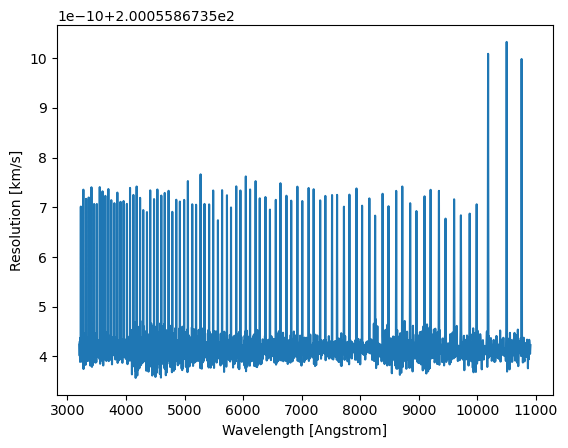

In [9]:
# if we plot the resolution as wavelength function
fig, ax = plt.subplots()
ax.plot(wavelength_grid_array[:-1], res)
ax.set_xlabel('Wavelength [Angstrom]')
ax.set_ylabel('Resolution [km/s]')
plt.show()

Reading all spectra

In [10]:
all_files = [files for files in os.listdir(path=PATH_INPUT) if '_raw' not in files]
print(f'The total amount of SNs to study will be: {len(all_files)}\n')

print('Some examples are: ...')
print(all_files[:5])

The total amount of SNs to study will be: 16284

Some examples are: ...
['SN2017awk.dat', 'iPTF15acs.dat', 'SN2020dro.dat', 'SN2007ql.dat', 'SN2017evc.dat']


Now we will try with an example

In [11]:
file   = all_files[0]

# Obtain the transient name
snname = file.split('.')[0]
print(f'The working supernova will be {snname} ...')

# Reading the spectra data
data = pd.read_csv(PATH_INPUT+file)

# Converting wavelength to log_wavelength
data["log10lambda"] = np.log10(data["lambda"])

# fool pandas to make it think log10lambda is days
data["log10lambda_idx"] = data["log10lambda"].apply(lambda x: pd.Timedelta(x, 'days'))
data.set_index("log10lambda_idx", inplace=True)
data.head()

The working supernova will be SN2017awk ...


,mjd,lambda,flux_lambda,e_flux_lambda,instrument,log10lambda
log10lambda_idx,,,,,,
3 days 13:29:42.103489041,57802.1,3650.000000,1.014490e-16,NaN,Ekar_AFOSC_None_0.asc,3.562293
3 days 13:30:30.997953512,57802.1,3654.759239,1.792609e-16,NaN,Ekar_AFOSC_None_0.asc,3.562859
3 days 13:31:19.828788867,57802.1,3659.518477,2.164861e-16,NaN,Ekar_AFOSC_None_0.asc,3.563424
3 days 13:32:08.596160511,57802.1,3664.277716,1.727966e-16,NaN,Ekar_AFOSC_None_0.asc,3.563988
3 days 13:32:57.300233182,57802.1,3669.036955,4.956066e-17,NaN,Ekar_AFOSC_None_0.asc,3.564552


Show wavelength resolution in km/s, note that it increases with wavelength.

$$ v \approx \frac{d\lambda}{\lambda} \times c = d\ln \lambda \times c = d\log \lambda \times \ln(10) \times c$$

Then, the resolution will be

In [12]:
res = np.abs(data.log10lambda[:-1].values - data.log10lambda[1:].values) * np.log(10) * CSPEED
res

array([390.91550354, 390.40678325, 389.8993853 , ..., 181.0031925 ,
       180.89405116, 180.78504137])

In [13]:
dv = 200 # km/s, using values to show the effect
dvsmooth = 2000 # km/s

data = data.sort_index()

dlog10lambda = dv / CSPEED / np.log(10) * 24 * 3600 # pseudo seconds

We will convolve the observed spectra with a kernel width of half the desired loglambda grid (km/s) and will use a 500 km/s smoothing kernel to define a continuum.

In [14]:
dv = 200 # km/s, using values to show the effect
dvsmooth = 2000 # km/s

How many seconds would dlog10lambda correspond to? (remember we are fooling pandas)

In [15]:
dlog10lambda = dv / CSPEED / np.log(10) * 24 * 3600 # pseudo seconds
dlog10lambda

25.015362157627305

And dlog10lambdasmooth? (remember we are fooling pandas)

In [16]:
dlog10lambdasmooth = dvsmooth / CSPEED / np.log(10) * 24 * 3600 # pseudo seconds
dlog10lambdasmooth

250.15362157627305

Plot original and smoothed versions

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

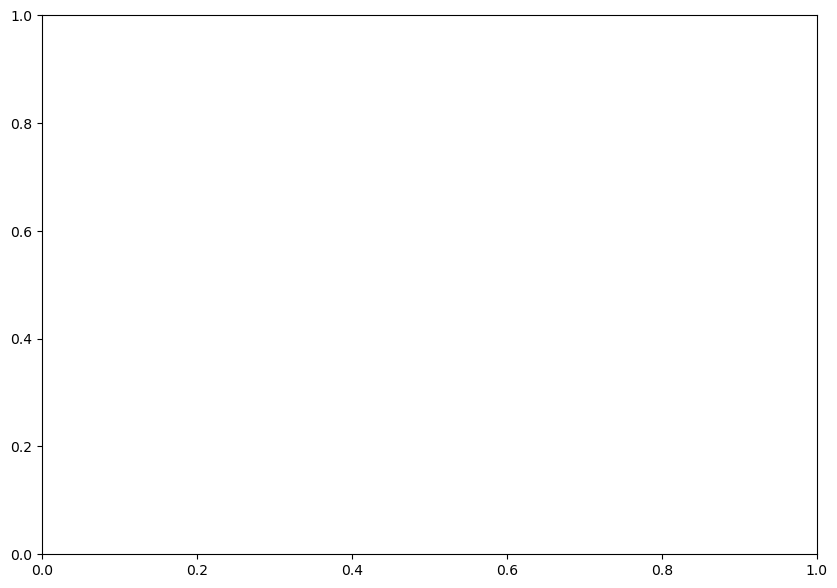

In [17]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(data["lambda"], data.flux_lambda, marker='o', alpha=0.5)
ax.plot(data["lambda"], data.flux_lambda.rolling(f'{int(dlog10lambda)}s', center=True).mean(), alpha=0.5)
ax.plot(data["lambda"], data.flux_lambda.rolling(f'{int(dlog10lambdasmooth)}s', center=True).mean(), c='r', lw=4, alpha=0.5)
ax.set_xlabel(r"$\lambda$ [A]")
plt.show()

Get km/s w.r.t. FeII. 

WARNING: this assumes that the spectra is in rest frame wavelength

In [ ]:
FeII = 5169
data["vFeII"] = (data["lambda"] - FeII) / FeII * CSPEED

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

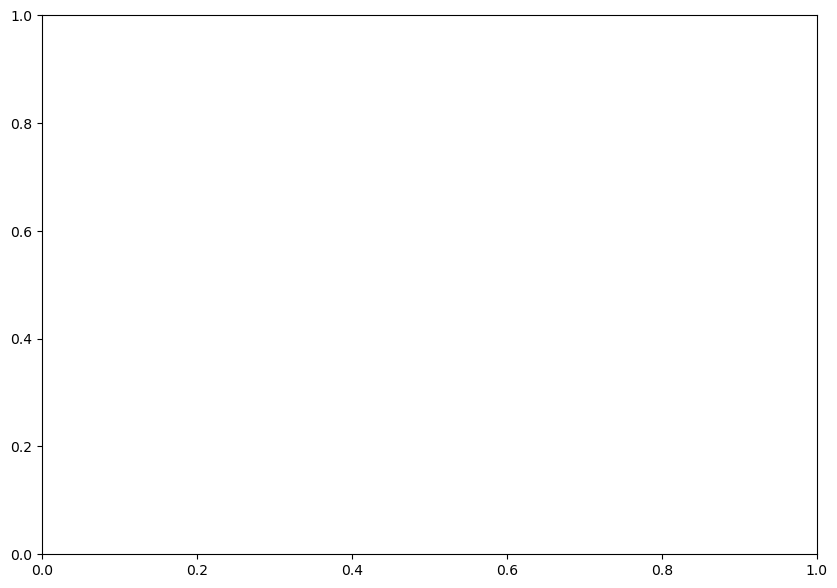

In [18]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(data["lambda"], data.flux_lambda, marker='o', alpha=0.5)
ax.plot(data["lambda"], data.flux_lambda.rolling(f'{int(dlog10lambda)}s', center=True).mean(), alpha=0.5)
ax.plot(data["lambda"], data.flux_lambda.rolling(f'{int(dlog10lambdasmooth)}s', center=True).mean(), c='r', lw=4, alpha=0.5)
ax.axvline(FeII)
ax.set_xlabel(r"$\lambda$ [A]")
plt.show()

Plot dispersion w.r.t. smoothed version (use as empirical error)

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

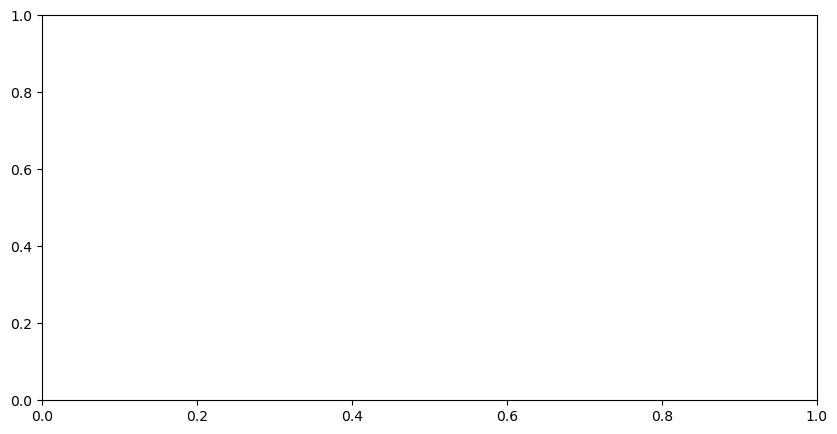

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(data["lambda"], data.flux_lambda - data.flux_lambda.rolling(f'{int(dlog10lambda)}s', center=True).mean())
ax.plot(data["lambda"], (data.flux_lambda.rolling(f'{int(dlog10lambda)}s', center=True).mean() - data.flux_lambda.rolling(f'{int(dlog10lambdasmooth)}s', center=True).mean()))
delta = (data.flux_lambda.rolling(f'{int(dlog10lambda)}s', center=True).mean() - data.flux_lambda.rolling(f'{int(dlog10lambdasmooth)}s', center=True).mean()).rolling(f'{int(dlog10lambdasmooth)}s', center=True).std()
ax.plot(data["lambda"], -delta, c='gray')
ax.plot(data["lambda"], delta, c='gray')
ax.set_xlabel(r"$\lambda$ [A]")

plt.show()

From this point I will generalizate all the calculations to all supernovae

In [12]:
def smooth_flux(data:pd.DataFrame, dv:float = 200, dvsmooth:float = 2000) -> pd.DataFrame:
    """
    
    Params
    ------
    data: pd.DataFrame with the spectra data
    dv: velocity 

    Return
    ------
    pd.Dataframe mainly flux rolled of the log_lambda
    """

    CSPEED = 3e5 # light_speed in km/s

    dlog10lambda = dv / CSPEED / np.log(10) * (24 * 3600) # pseudo seconds
    dlog10lambdasmooth = dvsmooth / CSPEED / np.log(10) * 24 * 3600 # pseudo seconds

    data["log10lambda"] = np.log10(data["lambda"])

    # fool pandas to make it think log10lambda is days
    data["log10lambda_idx"] = data["log10lambda"].apply(lambda x: pd.Timedelta(x, 'days'))

    result = []
    for name, group in data.groupby('mjd'):
        group = group.set_index('log10lambda_idx').sort_index()
        group["flux_log10lambda_rolling"] = group.flux_lambda.rolling(f'{int(dlog10lambda)}s', center=True).mean()
        group["eflux_log10lambda_rolling"] = (group.flux_log10lambda_rolling - group.flux_lambda.rolling(f'{int(dlog10lambdasmooth)}s', center=True).mean()).rolling(f'{int(dlog10lambdasmooth)}s', center=True).std()
        result.append(group)
    data = pd.concat(result)
    data.reset_index(inplace=True)
    data = data.drop('log10lambda_idx',axis=1)
    data
    
    return data

In [13]:
def obtain_interpolated_flux(data:pd.DataFrame, lambda_grid:np.array) -> np.array:

    x, y = data['lambda'], data['flux_log10lambda_rolling']
    f = interpolate.interp1d(x, y, fill_value=np.nan, bounds_error=False)

    # computing the new flux in the lambda_grid
    flux_new = f(lambda_grid)

    return flux_new

In [14]:
# Lista para almacenar los resultados
def arrange_spectra(sn_name:str,data: pd.DataFrame,oid:int,
                    lambda_grid:np.array, nlambda_grid: int) -> pd.DataFrame:
    results = []
    for inst_name, inst_group in data.groupby('instrument'):
        for mjd, mjd_group in inst_group.groupby('mjd'):
            #flux_lambda = obtain_interpolated_flux(data=data, lambda_grid=lambda_grid)
            
            #flux_lambda, eflux_lambda

            data_flux = {
                'oid': oid,
                'snname':sn_name,
                'instrument': inst_name,
                'mjd': mjd,
                'lambda_grid_min': lambda_grid.min(),
                'lambda_grid_max': lambda_grid.max(),
                'nlambda_grid': nlambda_grid,
                'lambda_data_min': mjd_group['lambda'].min(),
                'lambda_data_max': mjd_group['lambda'].max(),
                'flux_lambda': mjd_group.flux_log10lambda_rolling.tolist(),
                'e_flux_lambda': mjd_group.eflux_log10lambda_rolling.tolist()}
            results.append(data_flux)

            oid += 1

    unique_table = pd.DataFrame(results)
    return unique_table, oid

In [28]:
master_dataframe = pd.DataFrame()
indx_ini = 14000
indx_fin = 18000
oid = indx_ini
for file in all_files[indx_ini:indx_fin]:
    try:
        sn_name = file.split('.')[0]
        data = pd.read_csv(PATH_INPUT+file)
        data = smooth_flux(data=data)
        result_table, oid = arrange_spectra(sn_name,data,oid, wavelength_grid_array, nwavelength_grid)
        master_dataframe = pd.concat([master_dataframe, result_table])
        oid = oid
    except:
        continue

In [25]:
master_dataframe = pd.DataFrame()
indx_ini = 10000
indx_fin = 14000
oid = indx_ini
for file in all_files[indx_ini:indx_fin]:
    sn_name = file.split('.')[0]
    data = pd.read_csv(PATH_INPUT+file)
    data = smooth_flux(data=data)
    result_table, oid = arrange_spectra(sn_name,data,oid, wavelength_grid_array, nwavelength_grid)
    master_dataframe = pd.concat([master_dataframe, result_table])
    oid = oid

TypeError: loop of ufunc does not support argument 0 of type str which has no callable log10 method

In [29]:
master_dataframe.to_pickle(f'./master_spectra_table_{indx_ini}_{indx_fin}.pkl')

In [38]:
master_dataframe = pd.read_pickle(f'./master_spectra_table_0_100.pkl')
master_dataframe[10:20]

,oid,snname,instrument,mjd,lambda_grid_min,lambda_grid_max,nlambda_grid,lambda_data_min,lambda_data_max,flux_lambda,e_flux_lambda
0,10,SN2018lrd,LT_SPRAT_TNS.ascii,58965.347789,3206.34,10915.01,1838,4020.00,7994.40,"[1.27604, 1.43126, 1.24656, 1.3577, 1.39855, 1...","[0.13499846964153167, 0.11676215141775911, 0.1..."
0,11,SN2022mon,HET_HET-LRS_TNS.dat,59775.429896,3206.34,10915.01,1838,3640.00,6950.00,"[1.1336319e-17, 1.0081793750000001e-17, 9.3573...","[3.918386425908685e-18, 3.846224907809454e-18,..."
0,12,SN2024jfl,UH88_SNIFS_TNS.dat,60475.549063,3206.34,10915.01,1838,3400.48,9097.48,"[-3.4805520000000004e-17, -1.428329e-17, 3.929...","[3.1713550130484654e-17, 3.035320808598844e-17..."
0,13,SN2023hyv,P60_SEDM_TNS.ascii,60085.232731,3206.34,10915.01,1838,3776.70,9223.30,"[4.163e-16, 7.484e-16, 7.174e-16, 9.65e-16, 6....","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
0,14,SN2019btu,P60_SEDM_TNS.ascii,58559.947882,3206.34,10915.01,1838,3776.70,9223.30,"[3.386e-15, 2.155e-15, 2.969e-15, 1.153e-15, 2...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
0,15,SN2021jvp,UH88_SNIFS_TNS.dat,59323.491771,3206.34,10915.01,1838,5101.13,9197.27,"[5.792229000000001e-17, 6.187068000000001e-17,...","[1.8644373192862318e-17, 1.708713217169303e-17..."
0,16,SN2023hro,ANU-2.3m_WiFeS_TNS.dat,60075.500000,3206.34,10915.01,1838,3502.32,8999.31,"[6.18675, 5.630966666666667, 9.540366666666666...","[8.23509771574696, 8.357723510199829, 8.443843..."
1,17,SN2023hro,Other_Other_TNS.dat,60072.771505,3206.34,10915.01,1838,4089.39,7960.40,"[11.228100000000001, 16.08706, 24.3512, 22.938...","[5.379808087925319, 6.2415617959222605, 6.7118..."
2,18,SN2023hro,P60_SEDM_TNS.ascii,60075.318160,3206.34,10915.01,1838,3776.70,9223.30,"[4.520700000000001, 4.219325000000001, 6.07100...","[1.5964183728509782, 1.934424666569116, 1.3426..."
0,19,SN2018lpi,P60_SEDM_TNS.ascii,58334.229560,3206.34,10915.01,1838,3807.70,9178.40,"[3.0334e-17, 2.812e-17, 3.3065e-17, 5.5451e-17...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


In [8]:
master_dataframe = pd.read_pickle(f'./spectra_wisrep_20240622.pkl')
master_dataframe = master_dataframe.drop(master_dataframe.columns[0], axis=1)

In [11]:
master_dataframe

,snname,instrument,mjd,lambda_grid_min,lambda_grid_max,nlambda_grid,lambda_data_min,lambda_data_max,flux_lambda,e_flux_lambda
0,SN2022pru,Lick-3m_KAST_TNS.flm,59788.215972,3206.34,10915.01,1838,3504.527001,10393.131809,"[2.2633771763432984, 2.7388705744561315, 2.365...","[0.21898910712578754, 0.1979063641775711, 0.18..."
0,SN2022ytx,LT_SPRAT_TNS.txt,59886.979942,3206.34,10915.01,1838,4047.600000,7994.400000,"[-1.149378218494491, -0.4815124591937457, 0.58...","[0.02170248062794458, 0.36034818699792165, 0.2..."
1,SN2022ytx,LT_SPRAT_TNS.txt,59907.898866,3206.34,10915.01,1838,4066.000000,7994.400000,"[0.5816700646397295, 0.42704860952865736, 0.28...","[0.2633190522450036, 0.12698204152460923, 0.16..."
0,SNLS-07D3do,Gemini-N_GMOS_SNLS.dat,54200.000000,3206.34,10915.01,1838,5104.440000,9352.610000,"[1.3701777199999997e-18, 5.391721933333332e-19...","[1.5368479599410815e-18, 1.394673534721022e-18..."
1,SNLS-07D3do,Gemini-N_GMOS_SNLS_0.dat,54200.000000,3206.34,10915.01,1838,5048.346943,9355.344674,"[1.4337395000000001e-18, 6.124360000000001e-19...","[1.797687567656606e-18, 1.8212694935234954e-18..."
...,...,...,...,...,...,...,...,...,...,...
0,SN2021efd,NOT_ALFOSC_TNS.txt,59277.154005,3206.34,10915.01,1838,3399.900000,9675.765091,"[1.380389e-16, -2.7406190000000003e-17, 7.2966...","[9.342260744967236e-17, 8.189705456575588e-17,..."
0,SN2020etk,LT_SPRAT_TNS.ascii,58970.392257,3206.34,10915.01,1838,4020.000000,7994.400000,"[1.36587, 1.90187, 1.33649, 1.34496, 1.45294, ...","[0.44910237291240807, 0.34667301062037215, 0.2..."
0,SN2020oqp,P60_SEDM_TNS.ascii,59047.214850,3206.34,10915.01,1838,3776.700000,9223.300000,"[2.82e-16, 2.642e-16, 2.681e-16, 2.844e-16, 3....","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
0,SDSS-SN-082,Sloan_SDSS-Spec_SDSS-SNe.dat,54233.000000,3206.34,10915.01,1838,3822.082000,9189.671900,"[1.1208449500000001e-17, 1.6475109666666668e-1...","[1.1354836383504999e-17, 1.118140824452677e-17..."


In [23]:
sn_data = master_dataframe.iloc[0]
test = sn_data['flux_lambda']
test

'[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 1.2766758573294896e-16,

TypeError: no numeric data to plot

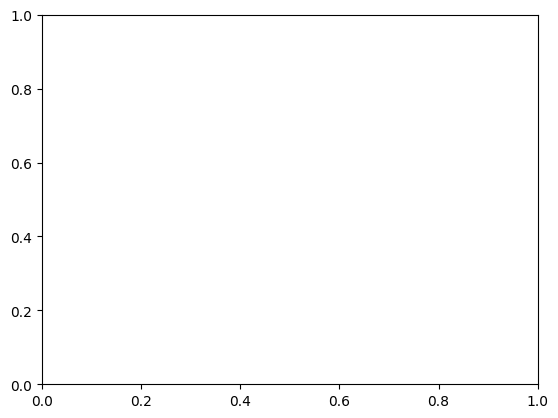

In [24]:
sn_data = master_dataframe.iloc[0]
x = np.logspace(np.log10(sn_data.lambda_grid_min),np.log10(sn_data.lambda_grid_max),sn_data.nlambda_grid)
y = sn_data.flux_lambda
fig, ax = plt.subplots()
sn_data.plot(x=x, y='flux_lambda')

In [12]:
len(master_dataframe.snname.unique())

16281

In [5]:
import psycopg2
import requests 
credentials_file = "https://raw.githubusercontent.com/alercebroker/usecases/master/alercereaduser_v4.json"
params = requests.get(credentials_file).json()["params"]
conn = psycopg2.connect(dbname=params["dbname"], user=params["user"], host=params["host"], password=params["password"])

In [6]:
def ztf_crossmatch(conn, df, search_radius=1):
    '''
    conn: connection to database
    df: external catalog dataframe (with columns id_source, ra, dec)
    search_radius: external radius in arcsec (default=1)

    The output is a dataframe with the source id, ra, and dec,
    as well as the ALeRCE database meanra, meandec, the crossmatch distance
    in degrees and the time of first detection according to the ALeRCE database
    '''
    
    # Preparar el dataframe
    objects = []
    for _, row in df.iterrows():
        objects.append(f"(\'{row.id_source}\', {row.ra}, {row.dec}, \'{row.redshift}\', \'{row.true_label}\')")
    objects_str = ",\n".join(objects)

    # Convertir el radio a grados
    search_radius = search_radius / 3600

    # Preparar el query
    query = """
    WITH catalog (source_id, ra, dec, redshift, true_label) AS (
        VALUES
            {values}
    )
    SELECT 
        c.source_id, c.ra, c.dec, o.oid, o.meanra, o.meandec, q3c_dist(c.ra, c.dec, o.meanra, o.meandec), 
        o.firstmjd,
        c.redshift, c.true_label
    FROM object o, catalog c
    WHERE
        q3c_join(c.ra, c.dec, o.meanra, o.meandec, {radius})
    """

    # Formatear el query final
    query_str = query.format(values=objects_str, radius=search_radius)

    # Ejecutar el query
    try:
        matches = pd.read_sql(query_str,conn)
        matches["q3c_dist"] = matches.q3c_dist * 3600
        matches.rename({"q3c_dist": "dist_arcsec"}, axis=1, inplace=True)
        return matches
    except:
        print("Error accessing the database. Most common causes are timeout errors or wrongly formatted input query.")

In [7]:
supernovae_metadata = pd.read_csv('./wiserep_spectra_metadata.csv',low_memory=False)
supernovae_metadata.shape

(46451, 46)

In [8]:
supernovae_metadata.columns

Index(['Obj. ID', 'IAU name', 'Internal name/s', 'Obj. RA', 'Obj. DEC',
       'Obj. Type', 'Redshift', 'Spec. ID', 'Obs-date', 'JD', 'Phase (days)',
       'From', 'Telescope', 'Instrument', 'Observer/s', 'Reducer/s',
       'Source group', 'Public', 'Associated groups', 'End prop. period',
       'Ascii file', 'Fits file', 'Spec. type', 'Spec. quality',
       'Extinction-Corrected', 'WL Medium', 'WL Units',
       'Flux Unit Coefficient', 'Spec. units', 'Flux Calibrated By',
       'Exp-time', 'Aperture (slit)', 'HA', 'Airmass', 'Dichroic', 'Grism',
       'Grating', 'Blaze', 'Lambda-min', 'Lambda-max', 'Del-Lambda', 'Contrib',
       'Publish', 'Remarks', 'Created by', 'Creation date'],
      dtype='object')

In [9]:
supernovae_cross_names = [
    supernovae_metadata['Obj. ID'],
    supernovae_metadata['IAU name'], 
    supernovae_metadata['Internal name/s'].apply(lambda x: str(x).split(',')[0].strip() if pd.notnull(x) else x)
]
supernovae_cross_names[0].name, supernovae_cross_names[1].name, supernovae_cross_names[2].name = 'Obj. ID', 'IAU name', 'Internal name'
supernovae_cross_names = pd.concat(supernovae_cross_names, axis=1)
supernovae_cross_names

,Obj. ID,IAU name,Internal name
0,5875,SN 1999Z,NaN
1,5875,SN 1999Z,NaN
2,5875,SN 1999Z,NaN
3,5875,SN 1999Z,NaN
4,5875,SN 1999Z,NaN
...,...,...,...
46446,8896,SN 2016hhv,ATLAS16drn
46447,8896,SN 2016hhv,ATLAS16drn
46448,205,SN 2016hht,PS17aja
46449,427,SN 2016hhj,iPTF16hhj


In [10]:
dfsn = supernovae_metadata[["IAU name", "Obj. RA", "Obj. DEC", "Redshift", "Obj. Type"]].rename({"IAU name":"id_source",'Obj. RA': "ra","Obj. DEC":"dec", "Redshift": "redshift", "Obj. Type": "true_label"},axis=1)
results = ztf_crossmatch(conn, dfsn)
results

/tmp/ipykernel_32892/77672216.py:41: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  matches = pd.read_sql(query_str,conn)


,source_id,ra,dec,oid,meanra,meandec,dist_arcsec,firstmjd,redshift,true_label
0,SN 1990E,39.870830,-8.133610,ZTF22abqtedd,39.871056,-8.133666,0.830261,60257.273299,0.00414,SN IIP
1,SN 1990E,39.870830,-8.133610,ZTF22abqtedd,39.871056,-8.133666,0.830261,60257.273299,0.00414,SN IIP
2,SN 1990E,39.870830,-8.133610,ZTF22abqtedd,39.871056,-8.133666,0.830261,60257.273299,0.00414,SN IIP
3,SN 1990E,39.870830,-8.133610,ZTF22abqtedd,39.871056,-8.133666,0.830261,60257.273299,0.00414,SN IIP
4,SN 1990E,39.870830,-8.133610,ZTF22abqtedd,39.871056,-8.133666,0.830261,60257.273299,0.00414,SN IIP
...,...,...,...,...,...,...,...,...,...,...
13766,SN 2006nz,14.121710,-1.226690,ZTF18abshjwa,14.121738,-1.226778,0.331512,58364.386053,0.0381,SN Ia
13767,nan,168.274198,5.341922,ZTF23aahmxcr,168.274095,5.342035,0.550900,60058.297454,0.037,SN II
13768,SN 2016ieq,320.604958,-11.948561,ZTF19abkaxlf,320.604931,-11.948554,0.099859,58668.442280,0.066,SN IIn
13769,SN 2016ieq,320.604958,-11.948561,ZTF19abkaxlf,320.604931,-11.948554,0.099859,58668.442280,0.066,SN IIn


In [58]:
results.to_pickle('results_wiserep.pkl')

In [64]:
results.source_id = results.source_id.replace('nan',np.nan)


In [66]:
results = results.dropna()
results

,source_id,ra,dec,oid,meanra,meandec,dist_arcsec,firstmjd,redshift,true_label
0,SN 1990E,39.870830,-8.133610,ZTF22abqtedd,39.871056,-8.133666,0.830261,60257.273299,0.00414,SN IIP
1,SN 1990E,39.870830,-8.133610,ZTF22abqtedd,39.871056,-8.133666,0.830261,60257.273299,0.00414,SN IIP
2,SN 1990E,39.870830,-8.133610,ZTF22abqtedd,39.871056,-8.133666,0.830261,60257.273299,0.00414,SN IIP
3,SN 1990E,39.870830,-8.133610,ZTF22abqtedd,39.871056,-8.133666,0.830261,60257.273299,0.00414,SN IIP
4,SN 1990E,39.870830,-8.133610,ZTF22abqtedd,39.871056,-8.133666,0.830261,60257.273299,0.00414,SN IIP
...,...,...,...,...,...,...,...,...,...,...
13694,SN 2006nz,14.121710,-1.226690,ZTF18abshjwa,14.121738,-1.226778,0.331512,58364.386053,0.0381,SN Ia
13695,SN 2006nz,14.121710,-1.226690,ZTF18abshjwa,14.121738,-1.226778,0.331512,58364.386053,0.0381,SN Ia
13697,SN 2016ieq,320.604958,-11.948561,ZTF19abkaxlf,320.604931,-11.948554,0.099859,58668.442280,0.066,SN IIn
13698,SN 2016ieq,320.604958,-11.948561,ZTF19abkaxlf,320.604931,-11.948554,0.099859,58668.442280,0.066,SN IIn


In [32]:
supernovae_metadata['IAU name']

0          SN 1999Z
1          SN 1999Z
2          SN 1999Z
3          SN 1999Z
4          SN 1999Z
            ...    
46446    SN 2016hhv
46447    SN 2016hhv
46448    SN 2016hht
46449    SN 2016hhj
46450    SN 2016hhj
Name: IAU name, Length: 46451, dtype: object

In [67]:
test_supernovae_metadata = supernovae_metadata.set_index('IAU name')
test_supernovae_metadata

,Obj. ID,Internal name/s,Obj. RA,Obj. DEC,Obj. Type,Redshift,Spec. ID,Obs-date,JD,Phase (days),...,Grating,Blaze,Lambda-min,Lambda-max,Del-Lambda,Contrib,Publish,Remarks,Created by,Creation date
IAU name,,,,,,,,,,,,,,,,,,,,,
SN 1999Z,5875,NaN,155.655130,27.355500,SN IIn,0.051000,17656,1999-02-09 00:00:00.00,2.451218e+06,NaN,...,NaN,NaN,3720.00000,7540.500000,1.499411,NaN,NaN,Data was ingested from the &lt;a href=&#039;ht...,Migration From WISeREP1.0,2013-07-08 09:12:53
SN 1999Z,5875,NaN,155.655130,27.355500,SN IIn,0.051000,17657,1999-02-10 00:00:00.00,2.451220e+06,NaN,...,NaN,NaN,3720.00000,7540.500000,1.499411,NaN,NaN,Data was ingested from the &lt;a href=&#039;ht...,Migration From WISeREP1.0,2013-07-08 09:12:53
SN 1999Z,5875,NaN,155.655130,27.355500,SN IIn,0.051000,17658,1999-02-13 00:00:00.00,2.451222e+06,NaN,...,NaN,NaN,3720.00000,7540.500000,1.499411,NaN,NaN,Data was ingested from the &lt;a href=&#039;ht...,Migration From WISeREP1.0,2013-07-08 09:12:53
SN 1999Z,5875,NaN,155.655130,27.355500,SN IIn,0.051000,17659,1999-02-23 00:00:00.00,2.451232e+06,NaN,...,NaN,NaN,3720.00000,7540.500000,1.499411,NaN,NaN,Data was ingested from the &lt;a href=&#039;ht...,Migration From WISeREP1.0,2013-07-08 09:12:53
SN 1999Z,5875,NaN,155.655130,27.355500,SN IIn,0.051000,17660,1999-04-10 00:00:00.00,2.451278e+06,NaN,...,NaN,NaN,3720.00000,7540.500000,1.499411,NaN,NaN,Data was ingested from the &lt;a href=&#039;ht...,Migration From WISeREP1.0,2013-07-08 09:12:53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SN 2016hhv,8896,ATLAS16drn,353.952000,20.708800,SN Ia,0.062000,27007,2016-11-03 00:32:00.00,2.457696e+06,NaN,...,Free,NaN,3634.04834,9229.227457,5.512492,NaN,NaN,NaN,Migration From WISeREP1.0,2016-11-03 14:12:30
SN 2016hhv,8896,ATLAS16drn,353.952000,20.708800,SN Ia,0.062000,74901,2016-11-03 00:32:00.00,2.457696e+06,NaN,...,NaN,NaN,3632.11000,9229.439000,5.514610,NaN,NaN,Released as part of DR4,WIS_Bot1,2023-05-04 14:04:01
SN 2016hht,205,"PS17aja, Gaia16bvb, ASASSN-16lx",156.022180,16.741020,SN Ia,0.019000,554,2016-10-23 19:12:00.00,2.457685e+06,NaN,...,NaN,NaN,5000.00000,9000.000000,3.996004,NaN,NaN,[TNS Source Group: NA; Classifier/s: Miho Kawa...,Migration From WISeREP1.0,2016-10-22 01:27:52


In [68]:
test_supernovae_metadata[results.source_id]

KeyError: "None of [Index(['SN 1990E', 'SN 1990E', 'SN 1990E', 'SN 1990E', 'SN 1990E', 'SN 1990E',\n       'SN 1990E', 'SN 1990E', 'SN 1990E', 'SN 1990E',\n       ...\n       'SN 2017aym', 'SN 2017aym', 'SN 2016Z', 'SN 2016nx', 'SN 2006nz',\n       'SN 2006nz', 'SN 2006nz', 'SN 2016ieq', 'SN 2016ieq', 'SN 2016ieq'],\n      dtype='object', length=13589)] are in the [columns]"

In [11]:
new_results = results.drop_duplicates(subset='source_id',keep='first').reset_index(drop=True)
new_results = new_results[['oid','source_id','true_label','firstmjd','redshift','ra','dec','meanra','meandec']]

In [15]:
new_results.to_pickle('ALERCExWiserp20240721_to_AvMW.pkl')
new_results

,oid,source_id,true_label,firstmjd,redshift,ra,dec,meanra,meandec
0,ZTF22abqtedd,SN 1990E,SN IIP,60257.273299,0.00414,39.870830,-8.133610,39.871056,-8.133666
1,ZTF24aaekmnz,SN 2024yr,SN II,60351.498808,0.02,239.896375,-13.153481,239.896379,-13.153415
2,ZTF24aabvtdh,SN 2024yq,SN Ia,60324.494931,0.04,211.964404,-10.061706,211.964383,-10.061704
3,ZTF24aabplhb,SN 2024ym,SN Ia,60322.398276,0.038,152.905843,74.993897,152.905856,74.993914
4,ZTF24aabuisb,2024xx,SN Ia,60322.324630,0.05437,137.472042,35.705492,137.472050,35.705507
...,...,...,...,...,...,...,...,...,...
9721,ZTF21abljmmv,SN 2021tgb,SN Ia,59408.315359,0.05,297.505521,-20.164683,297.505527,-20.164679
9722,ZTF21abkrteb,SN 2021tfx,SN Ia,59406.202882,0.07295,215.583357,47.934202,215.583357,47.934222
9723,ZTF22abntkbk,SN 2016nx,SN Ia,59870.374664,0.089,57.039590,10.269090,57.039556,10.269070
9724,ZTF18abshjwa,SN 2006nz,SN Ia,58364.386053,0.0381,14.121710,-1.226690,14.121738,-1.226778


In [16]:
new_SN_cross_names = supernovae_cross_names.drop_duplicates(subset='Obj. ID',keep='first').reset_index(drop=True)#.set_index('IAU name')
new_SN_cross_names

,Obj. ID,IAU name,Internal name
0,5875,SN 1999Z,NaN
1,6732,SN 1999X,NaN
2,5821,SN 1999U,NaN
3,1885,SN 1999S,NaN
4,1545,SN 1999Q,NaN
...,...,...,...
19924,935,SN 2016hid,PS16exz
19925,3311,SN 2016hhz,Gaia16cae
19926,8896,SN 2016hhv,ATLAS16drn
19927,205,SN 2016hht,PS17aja


In [22]:
crossmatched = pd.merge(left=new_results, right=new_SN_cross_names, how='inner', left_on='source_id', right_on='IAU name')[['source_id','IAU name','Internal name','oid']]
crossmatched.source_id = crossmatched.source_id.apply(lambda x: x.replace(' ',''))
crossmatched

,source_id,IAU name,Internal name,oid
0,SN1990E,SN 1990E,NaN,ZTF22abqtedd
1,SN2024yr,SN 2024yr,PS24ara,ZTF24aaekmnz
2,SN2024yq,SN 2024yq,ZTF24aabvtdh,ZTF24aabvtdh
3,SN2024ym,SN 2024ym,ZTF24aabplhb,ZTF24aabplhb
4,2024xx,2024xx,ATLAS24auj,ZTF24aabuisb
...,...,...,...,...
9720,SN2021tgb,SN 2021tgb,ATLAS21bbue,ZTF21abljmmv
9721,SN2021tfx,SN 2021tfx,ZTF21abkrteb,ZTF21abkrteb
9722,SN2016nx,SN 2016nx,PS16pb,ZTF22abntkbk
9723,SN2006nz,SN 2006nz,NaN,ZTF18abshjwa


In [21]:
master_dataframe

,oid,snname,instrument,mjd,lambda_grid_min,lambda_grid_max,nlambda_grid,lambda_data_min,lambda_data_max,flux_lambda,e_flux_lambda
0,6000,SN2022pru,Lick-3m_KAST_TNS.flm,59788.215972,3206.34,10915.01,1838,3504.527001,10393.131809,"[2.2633771763432984, 2.7388705744561315, 2.365...","[0.21898910712578754, 0.1979063641775711, 0.18..."
0,6001,SN2022ytx,LT_SPRAT_TNS.txt,59886.979942,3206.34,10915.01,1838,4047.600000,7994.400000,"[-1.149378218494491, -0.4815124591937457, 0.12...","[0.2513674591903225, 0.2889965846960843, 0.113..."
1,6002,SN2022ytx,LT_SPRAT_TNS.txt,59907.898866,3206.34,10915.01,1838,4066.000000,7994.400000,"[1.04165, 0.844701, 0.877304, 1.13425, 0.71361...","[0.12373791200226614, 0.10053409443820172, 0.1..."
0,6003,SNLS-07D3do,Gemini-N_GMOS_SNLS.dat,54200.000000,3206.34,10915.01,1838,5104.440000,9352.610000,"[1.3701777199999997e-18, 5.391721933333332e-19...","[1.5368479599410815e-18, 1.394673534721022e-18..."
1,6004,SNLS-07D3do,Gemini-N_GMOS_SNLS_0.dat,54200.000000,3206.34,10915.01,1838,5048.346943,9355.344674,"[1.4337395000000001e-18, 6.124360000000001e-19...","[1.797687567656606e-18, 1.8212694935234954e-18..."
...,...,...,...,...,...,...,...,...,...,...,...
0,2906,SN2021efd,NOT_ALFOSC_TNS.txt,59277.154005,3206.34,10915.01,1838,3399.900000,9675.765091,"[1.380389e-16, -2.7406190000000003e-17, 7.2966...","[9.342260744967236e-17, 8.189705456575588e-17,..."
0,2907,SN2020etk,LT_SPRAT_TNS.ascii,58970.392257,3206.34,10915.01,1838,4020.000000,7994.400000,"[1.36587, 1.90187, 1.33649, 1.34496, 1.45294, ...","[0.44910237291240807, 0.34667301062037215, 0.2..."
0,2908,SN2020oqp,P60_SEDM_TNS.ascii,59047.214850,3206.34,10915.01,1838,3776.700000,9223.300000,"[2.82e-16, 2.642e-16, 2.681e-16, 2.844e-16, 3....","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
0,2909,SDSS-SN-082,Sloan_SDSS-Spec_SDSS-SNe.dat,54233.000000,3206.34,10915.01,1838,3822.082000,9189.671900,"[1.1208449500000001e-17, 1.6475109666666668e-1...","[1.1354836383504999e-17, 1.118140824452677e-17..."


In [25]:
cross_master = master_dataframe.merge(crossmatched[['source_id','oid']], how='left', left_on='snname',right_on='source_id').drop('source_id',axis=1)
cross_master = cross_master.merge(crossmatched[['Internal name','oid']], how='left', left_on='snname',right_on='Internal name', suffixes=('', '_new')).drop('Internal name',axis=1)
cross_master['oid'] = cross_master['oid_x'].combine_first(cross_master['oid'])
cross_master = cross_master.drop('oid_x',axis=1)
cross_master = cross_master[['oid','snname', 'instrument', 'mjd', 'lambda_grid_min', 'lambda_grid_max',
       'nlambda_grid', 'lambda_data_min', 'lambda_data_max', 'flux_lambda',
       'e_flux_lambda']]
cross_master.reset_index(drop=True)
cross_master.instrument = cross_master.instrument.apply(lambda x: ('_').join(x.split('_')[0:2])) 
cross_master

/tmp/ipykernel_32892/724026327.py:3: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  cross_master['oid'] = cross_master['oid_x'].combine_first(cross_master['oid'])


,oid,snname,instrument,mjd,lambda_grid_min,lambda_grid_max,nlambda_grid,lambda_data_min,lambda_data_max,flux_lambda,e_flux_lambda
0,6000,SN2022pru,Lick-3m_KAST,59788.215972,3206.34,10915.01,1838,3504.527001,10393.131809,"[2.2633771763432984, 2.7388705744561315, 2.365...","[0.21898910712578754, 0.1979063641775711, 0.18..."
1,6001,SN2022ytx,LT_SPRAT,59886.979942,3206.34,10915.01,1838,4047.600000,7994.400000,"[-1.149378218494491, -0.4815124591937457, 0.12...","[0.2513674591903225, 0.2889965846960843, 0.113..."
2,6002,SN2022ytx,LT_SPRAT,59907.898866,3206.34,10915.01,1838,4066.000000,7994.400000,"[1.04165, 0.844701, 0.877304, 1.13425, 0.71361...","[0.12373791200226614, 0.10053409443820172, 0.1..."
3,6003,SNLS-07D3do,Gemini-N_GMOS,54200.000000,3206.34,10915.01,1838,5104.440000,9352.610000,"[1.3701777199999997e-18, 5.391721933333332e-19...","[1.5368479599410815e-18, 1.394673534721022e-18..."
4,6004,SNLS-07D3do,Gemini-N_GMOS,54200.000000,3206.34,10915.01,1838,5048.346943,9355.344674,"[1.4337395000000001e-18, 6.124360000000001e-19...","[1.797687567656606e-18, 1.8212694935234954e-18..."
...,...,...,...,...,...,...,...,...,...,...,...
25948,2906,SN2021efd,NOT_ALFOSC,59277.154005,3206.34,10915.01,1838,3399.900000,9675.765091,"[1.380389e-16, -2.7406190000000003e-17, 7.2966...","[9.342260744967236e-17, 8.189705456575588e-17,..."
25949,2907,SN2020etk,LT_SPRAT,58970.392257,3206.34,10915.01,1838,4020.000000,7994.400000,"[1.36587, 1.90187, 1.33649, 1.34496, 1.45294, ...","[0.44910237291240807, 0.34667301062037215, 0.2..."
25950,2908,SN2020oqp,P60_SEDM,59047.214850,3206.34,10915.01,1838,3776.700000,9223.300000,"[2.82e-16, 2.642e-16, 2.681e-16, 2.844e-16, 3....","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
25951,2909,SDSS-SN-082,Sloan_SDSS-Spec,54233.000000,3206.34,10915.01,1838,3822.082000,9189.671900,"[1.1208449500000001e-17, 1.6475109666666668e-1...","[1.1354836383504999e-17, 1.118140824452677e-17..."


In [26]:
cross_master.to_pickle('spectra_ALeRCE20240721_x_wisrep_20240622.pkl')

In [86]:
hola = pd.read_pickle('spectra_ALeRCE20240630_x_wisrep_20240622.pkl')
hola

,oid,snname,instrument,mjd,lambda_grid_min,lambda_grid_max,nlambda_grid,lambda_data_min,lambda_data_max,flux_lambda,e_flux_lambda
0,NaN,SN2021aefs,ESO-NTT,59560.313577,3206.34,10915.01,1838,3651.341553,9244.899935,"[1.91091e-16, 1.82705e-16, 1.97729e-16, 1.8812...","[7.185204317077444e-18, 1.5696079042524182e-17..."
1,NaN,SN2021aefs,P60,59559.436690,3206.34,10915.01,1838,3651.341553,9244.899935,"[1.91091e-16, 1.82705e-16, 1.97729e-16, 1.8812...","[7.185204317077444e-18, 1.5696079042524182e-17..."
2,ZTF20aburywx,SN2020rsc,Keck1,59226.000000,3206.34,10915.01,1838,3077.048800,10304.617000,"[2.03112e-16, 2.94057e-16, 2.56117e-16, 3.6180...","[5.4224405104354494e-17, 5.302190662866851e-17..."
3,NaN,SN2011kg,HST,55943.000000,3206.34,10915.01,1838,1903.618857,10615.877400,"[0.2298616, 0.1718295, 0.1137441, 0.0555966, -...","[0.0374385692592133, 0.03915660996486737, 0.04..."
4,NaN,SN2011kg,Keck1,55926.000000,3206.34,10915.01,1838,1903.618857,10615.877400,"[0.2298616, 0.1718295, 0.1137441, 0.0555966, -...","[0.0374385692592133, 0.03915660996486737, 0.04..."
...,...,...,...,...,...,...,...,...,...,...,...
25948,NaN,PTF10tky,Mayall,55447.000000,3206.34,10915.01,1838,3499.337183,8435.216325,"[2.009414e-17, 5.0141400000000007e-17, 4.24290...","[1.7117255985857287e-17, 1.563774964810526e-17..."
25949,ZTF18aaqjjco,SN2005U,FLWO-1.5m,53402.400000,3206.34,10915.01,1838,3485.000000,7411.370000,"[5.508120990000001, 5.508120990000001, 5.50812...","[0.5603715492364529, 0.5603715492364529, 0.560..."
25950,ZTF18aaqjjco,SN2005U,FLWO-1.5m,53431.320000,3206.34,10915.01,1838,3485.000000,7411.370000,"[5.508120990000001, 5.508120990000001, 5.50812...","[0.5603715492364529, 0.5603715492364529, 0.560..."
25951,ZTF18aaqjjco,SN2005U,FLWO-1.5m,53443.350000,3206.34,10915.01,1838,3485.000000,7411.370000,"[5.508120990000001, 5.508120990000001, 5.50812...","[0.5603715492364529, 0.5603715492364529, 0.560..."


In [ ]:
# Datos de ejemplo
x = [0, 1, 2, 3, 4]
y = [0, 1, 0, 1, 0]

# Crear la función interpolante
f = interpolate.interp1d(x, y, fill_value=np.nan, bounds_error=False)

# Intentar interpolar fuera del rango
print(f([-1, 0.5, 5]))

wavelength_grid_array

x = data['lambda']
y = data['flux_log10lambda_rolling']




print(y_new)

plt.plot(x, y, 'o', x_new, y_new, '-')
plt.show()

[nan 0.5 nan]


In [ ]:
def obtain_flux_and_eflux(data, lambda_lenght):
    flambda, eflambda = [], []

    f
    for i in range(len(lambda_lenght)-1):
        flux    = data[(lambda_lenght[i] < data['lambda']) & (data['lambda'] < lambda_lenght[i+1])]['flux_lambda'].values
        eflux   = data[(lambda_lenght[i] < data['lambda']) & (data['lambda'] < lambda_lenght[i+1])]['e_flux_lambda'].values

        f
        
        if len(flux) == 0:
            flambda.append(np.nan)
        else:
            flambda.append(flux)
        if len(eflux) == 0:
            eflambda.append(np.nan)
        else:
            eflambda.append(eflux)

    lambda_min = data['lambda'].min()
    lambda_max = data['lambda'].max()

    return flambda, eflambda, lambda_min, lambda_max

In [ ]:
data_instrument = data.groupby('instrument')
data_instrument
for int, group in data_instrument:
    group.to_csv(f'{sn_name}_{int}.csv')

In [ ]:
sn_name = 'SN2006dv.dat'
data = pd.read_csv('./data/spectra/'+sn_name)

x_lambda_array = data['lambda']
y = data['flux_lambda']
f = interpolate.interp1d(x_lambda_array, y, fill_value=np.nan)

def plotobject(df,sn_name, inst_name):
  fig, ax = plt.subplots(figsize=(10, 6))
  for mjd_date, group_df in df.groupby('mjd'):
       ax.plot(group_df['lambda'], group_df['flux_lambda'], label=f'{mjd_date:.2f} MJD')
  ax.legend(frameon=False)
  ax.set_xlabel('Lambda')
  ax.set_ylabel('Flux_lambda')
  ax.set_title('Supernova:'+sn_name.split(".")[0]+" | Instrument: "+inst_name.split(".")[0])
  

data_instrument = data.groupby('instrument')
for inst_name, group in data_instrument:
    plotobject(group, sn_name=sn_name, inst_name=inst_name)

In [10]:
# Lista para almacenar los resultados
def arrange_spectra(sn_name,data,oid):
    results = []
    for inst_name, inst_group in data.groupby('instrument'):
        for mjd, mjd_group in inst_group.groupby('mjd'):
            flambda, eflambda, lambda_data_min, lambda_data_max = obtain_flux_eflux(mjd_group, lambda_grid_lenght)
            
            data_flux = {
                'oid': oid,
                'snname':sn_name,
                'instrument': inst_name,
                'mjd': mjd,
                'lambda_grid_min': lambda_grid_min,
                'lambda_grid_max': lambda_grid_max,
                'nlambda_grid': nlambda_grid,
                'lambda_data_min': lambda_data_min,
                'lambda_data_max': lambda_data_max,
                'flux_lambda': list(flambda),
                'e_flux_lambda':list(eflambda)}
            results.append(data_flux)

            oid += 1

    unique_table = pd.DataFrame(results)
    return unique_table, oid

In [ ]:
master_dataframe = pd.DataFrame()
indx_ini = 0
indx_fin = 12000
oid = 11000 - 1
for file in all_files[indx_ini:indx_fin]:
    sn_name = file.split('.')[0]
    data = pd.read_csv(PATH_input+file)
    result_table, oid = arrange_spectra(sn_name=sn_name, data=data,oid=oid)
    master_dataframe = pd.concat([master_dataframe, result_table])
    oid = oid

In [ ]:
master_dataframe.to_csv(f'./master_spectra_table_{indx_ini}_{indx_fin}.cvs')

In [1]:
import pandas as pd
import os

In [2]:
master_dataframe_list = [file for file in os.listdir(path='./') if file.startswith("master_spectra")]
master_dataframe_list.remove('master_spectra_wiserep.csv')
master_dataframe_list

['master_spectra_table_6000_10000.pkl',
 'master_spectra_table_14000_18000.pkl',
 'master_spectra_table_10000_14000.pkl',
 'master_spectra_table_2000_6000.pkl',
 'master_spectra_table_0_2000.pkl']

In [3]:
master_dataframe = pd.DataFrame()
for master_spectra_table in master_dataframe_list:
    data = pd.read_pickle(master_spectra_table)
    master_dataframe = pd.concat([master_dataframe, data])

In [4]:
master_dataframe.to_pickle(f'./master_spectra_table_main.pkl')

## Working with the DataFrame

In [ ]:
master_dataframe = pd.read_csv('master_spectra_table_main.cvs')
master_dataframe = master_dataframe.drop(['Unnamed: 0.1','Unnamed: 0'],axis=1)
master_dataframe.head()

In [ ]:
sn_dataframe = master_dataframe[master_dataframe['snname'] == 'SN2021rfs']
#sn_dataframe = sn_dataframe[0]
sn_dataframe

In [ ]:
sn_name = 'SN2021rfs.dat'
data = pd.read_csv('./data/spectra/'+sn_name)

def plotobject(df,sn_name, inst_name):
  fig, ax = plt.subplots(figsize=(10, 6))
  for mjd_date, group_df in df.groupby('mjd'):
       ax.plot(group_df['lambda'], group_df['flux_lambda'], label=f'{mjd_date:.2f} MJD')
  ax.legend(frameon=False)
  ax.set_xlabel('Lambda')
  ax.set_ylabel('Flux_lambda')
  ax.set_title('Supernova:'+sn_name.split(".")[0]+" | Instrument: "+inst_name.split(".")[0])
  

data_instrument = data.groupby('instrument')
for inst_name, group in data_instrument:
    plotobject(group, sn_name=sn_name, inst_name=inst_name)

In [ ]:
fig, ax = plt.subplots()
sn_dataframe.plot(x='flux_lambda',y=lambda_grid_lenght)


## Importing AstroDash

In [ ]:
import tensorflow as tf

In [ ]:
class ConvNetLayer(object):
    def __init__(self, N, ntypes, imWidth, imWidthReduc):
        self.N = N
        self.ntypes = ntypes
        self.imWidth = imWidth
        self.imWidthReduc = imWidthReduc

    def build_layer(self, prevHPool, prevNumFeatures, numFeatures):
        W_conv = self._weight_variable([5, 5, prevNumFeatures, numFeatures])
        b_conv = self._bias_variable([numFeatures])
        h_conv = tf.nn.relu(self._conv2d(prevHPool, W_conv) + b_conv)
        h_pool = self._max_pool_2x2(h_conv)
        # print(h_pool)

        return h_pool

    def connect_layers(self, h_pool, numFeatures, layerNum):
        W_fc = self._weight_variable(
            [int(self.imWidthReduc / layerNum * self.imWidthReduc / layerNum * numFeatures), 1024])
        b_fc = self._bias_variable([1024])
        h_pool_flat = tf.reshape(h_pool,
                                 [-1, int(self.imWidthReduc / layerNum * self.imWidthReduc / layerNum * numFeatures)])
        h_fc = tf.nn.relu(tf.matmul(h_pool_flat, W_fc) + b_fc)

        return h_fc

    def dropout(self, h_fc):
        keep_prob = tf.placeholder(tf.float32)
        h_fc_drop = tf.nn.dropout(h_fc, keep_prob)

        return keep_prob, h_fc_drop

    def readout_layer(self):
        W_fc = self._weight_variable([1024, self.ntypes])
        b_fc = self._bias_variable([self.ntypes])

        return W_fc, b_fc

    def _weight_variable(self, shape):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial)

    def _bias_variable(self, shape):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial)

    def _conv2d(self, x, W):
        return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

    def _max_pool_2x2(self, x):
        return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')


# Other things

In [10]:
import os
len([file for file in os.listdir(path='./data/spectra_wiserep_raws')])

3773